# Lecture 7: k-Means Applications

In this notebook, we apply k-Means to real-world problems:
1. **Penguins**: Elbow method to determine optimal K
2. **MNIST Digits**: Semi-supervised learning — label only cluster centers to classify thousands of samples
3. **Image Compression**: Reducing color palette

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix
import seaborn as sns
from IPython.display import display



%matplotlib inline

---
## Part 1: Elbow Method on Penguin Dataset

We will use the **Penguins** dataset (from Seaborn) to determine the optimal number of clusters using the **Elbow Method**.

The Penguins dataset contains data from three species. 

We cluster the data based on the features shown in the code below and try to find the best k. Ideally this should be 3, equal to the number of species.

In [111]:
# Load Penguin Data
from sklearn.preprocessing import StandardScaler

penguins = sns.load_dataset('penguins')
display(penguins.head())

# Remove rows with missing values
penguins = penguins.dropna()

# Select only the numeric features for clustering (ignore species, island, sex)
X_penguins = penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]

print(f"Features: {list(X_penguins.columns)}")
print(f"Samples: {len(X_penguins)}")

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


Features: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
Samples: 333


### Feature Scaling

Before clustering, we standardize features so they have equal influence. For example, without scaling, `body_mass_g` (thousands) would dominate `bill_length_mm` (tens).

**StandardScaler Usage:**
```python
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Transforms to mean=0, std=1
```

In [112]:
# TODO: Scale the penguin features using StandardScaler

### BEGIN SOLUTION
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_penguins)
### END SOLUTION

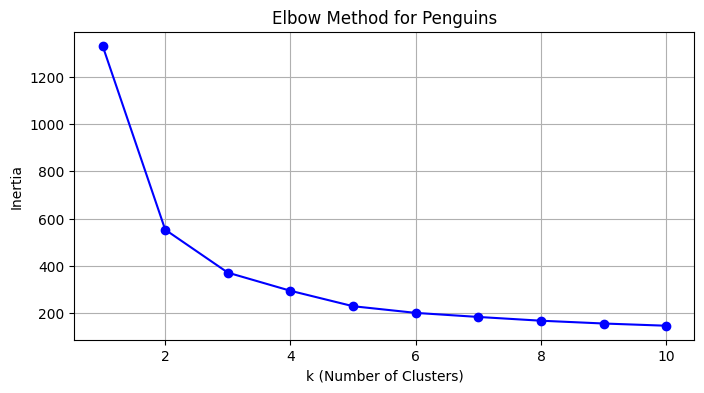

In [113]:
# Run K-Means for various K to find the Elbow
K_range = range(1, 11)

### BEGIN SOLUTION
inertias = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
### END SOLUTION
    
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('k (Number of Clusters)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Penguins')
plt.grid(True)
plt.show()

**Observation:** The curve bends at K=3, matching the 3 penguin species in the dataset. Beyond K=3, adding more clusters gives diminishing returns.

---
## Part 2: Semi-Supervised Learning on MNIST

Can k-Means discover the 10 digit classes without labels? We'll cluster handwritten digits and see how well clusters align with true digit classes.


In [114]:
# Load the MNIST dataset from OpenML (a public repository of datasets)
# 'mnist_784' contains 70,000 handwritten digit images, each 28x28 = 784 pixels
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# mnist.data contains the pixel values (each row is one flattened image)
X_digits = mnist.data.astype(np.float64)

# mnist.target contains the true digit labels (0-9)
y_digits = mnist.target.astype(int)

# Use a subset for faster computation
n_samples = 5000
X_digits = X_digits[:n_samples]
y_digits = y_digits[:n_samples]

print(f"Dataset shape: {X_digits.shape}")
print(f"Number of samples: {X_digits.shape[0]}")
print(f"Features per sample: {X_digits.shape[1]} (28x28 image flattened)")

Dataset shape: (5000, 784)
Number of samples: 5000
Features per sample: 784 (28x28 image flattened)


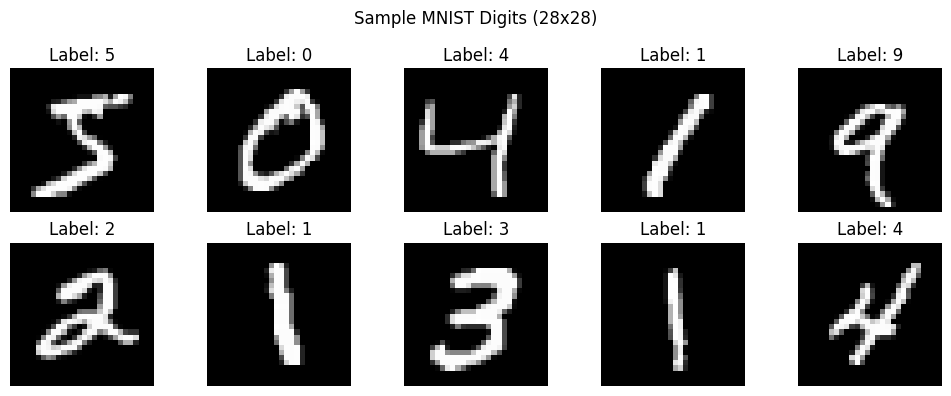

In [115]:
# Show some example digits
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    # Reshape from 784-element vector back to 28x28 image for display
    ax.imshow(X_digits[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {y_digits[i]}")
    ax.axis('off')
plt.suptitle("Sample MNIST Digits (28x28)")
plt.tight_layout()
plt.show()

### Attempt 1: K=10 Clusters

In [116]:
# Cluster into 10 groups (pretending we don't know there are 10 digits)

### BEGIN SOLUTION
kmeans_digits = KMeans(n_clusters=10, random_state=42, n_init=10)
kmeans_digits.fit(X_digits)

cluster_labels = kmeans_digits.labels_
centers = kmeans_digits.cluster_centers_
### END SOLUTION

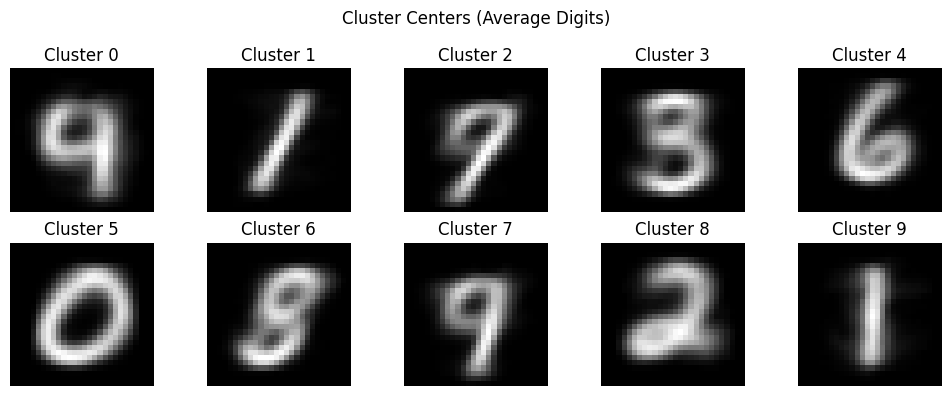

In [117]:
# Visualize the cluster centers ("average" digit in each cluster)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Reshape centers from (10, 784) to (10, 28, 28) for display
centers = centers.reshape(10, 28, 28)

for i, ax in enumerate(axes.flat):
    ax.imshow(centers[i], cmap='gray')
    ax.set_title(f"Cluster {i}")
    ax.axis('off')

plt.suptitle("Cluster Centers (Average Digits)")
plt.tight_layout()
plt.show()

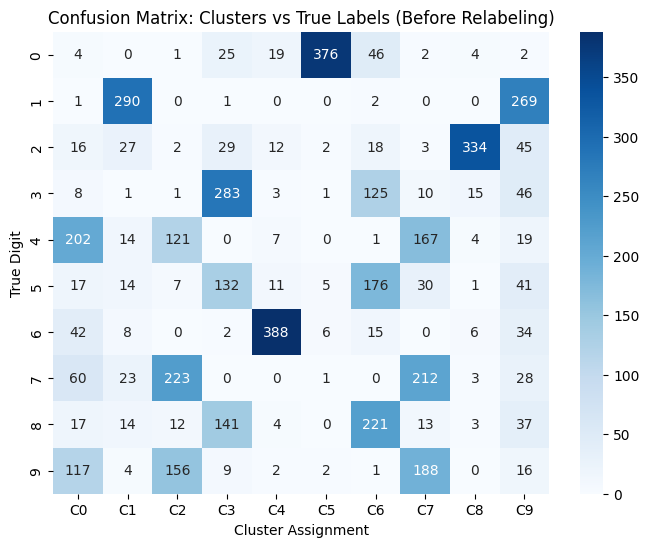


Accuracy with K=10 (best-case cluster-to-label mapping): 56.0%


In [118]:
# Confusion matrix: cluster assignments vs true labels
# Note: Cluster IDs (0-9) are arbitrary and don't correspond to digit labels!
cm_clusters = confusion_matrix(y_digits, cluster_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_clusters, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'C{i}' for i in range(10)], yticklabels=range(10))
plt.xlabel('Cluster Assignment')
plt.ylabel('True Digit')
plt.title('Confusion Matrix: Clusters vs True Labels (Before Relabeling)')
plt.show()

# Calculate accuracy by assigning each cluster to its most common digit
from scipy.stats import mode
from sklearn.metrics import accuracy_score

# For each cluster, find the most common true label among its members
cluster_to_label = {}
for cluster_id in range(10):
    # Get all samples assigned to this cluster
    mask = cluster_labels == cluster_id
    # Find the most frequent true label in this cluster
    most_common = mode(y_digits[mask], keepdims=True).mode[0]
    cluster_to_label[cluster_id] = most_common

# Predict labels based on cluster assignments
y_pred_k10 = np.array([cluster_to_label[c] for c in cluster_labels])
accuracy_k10 = accuracy_score(y_digits, y_pred_k10)
print(f"\nAccuracy with K=10 (best-case cluster-to-label mapping): {accuracy_k10:.1%}")

### Why K=10 doesn't work well

Looking at the confusion matrix, clusters don't cleanly separate the 10 digit classes — multiple digits get mixed into the same cluster.

**The problem:** With K=10, each cluster must represent exactly one digit. But digits have **variations** (different handwriting styles), so one cluster per digit isn't enough.

### Attempt 2: K=20 Clusters (Semi-Supervised)

**Solution:** Use more clusters (K=20) so each digit can have ~2 clusters for different writing styles. Then manually label each cluster by inspecting a few samples.

In [119]:
# Cluster with K=20 (more clusters than digit classes)

### BEGIN SOLUTION
kmeans_20 = KMeans(n_clusters=20, random_state=42, n_init=10)
kmeans_20.fit(X_digits)

cluster_labels_20 = kmeans_20.labels_
centers_20 = kmeans_20.cluster_centers_
### END SOLUTION

print(f"Clustered {len(X_digits)} samples into 20 clusters")

Clustered 5000 samples into 20 clusters


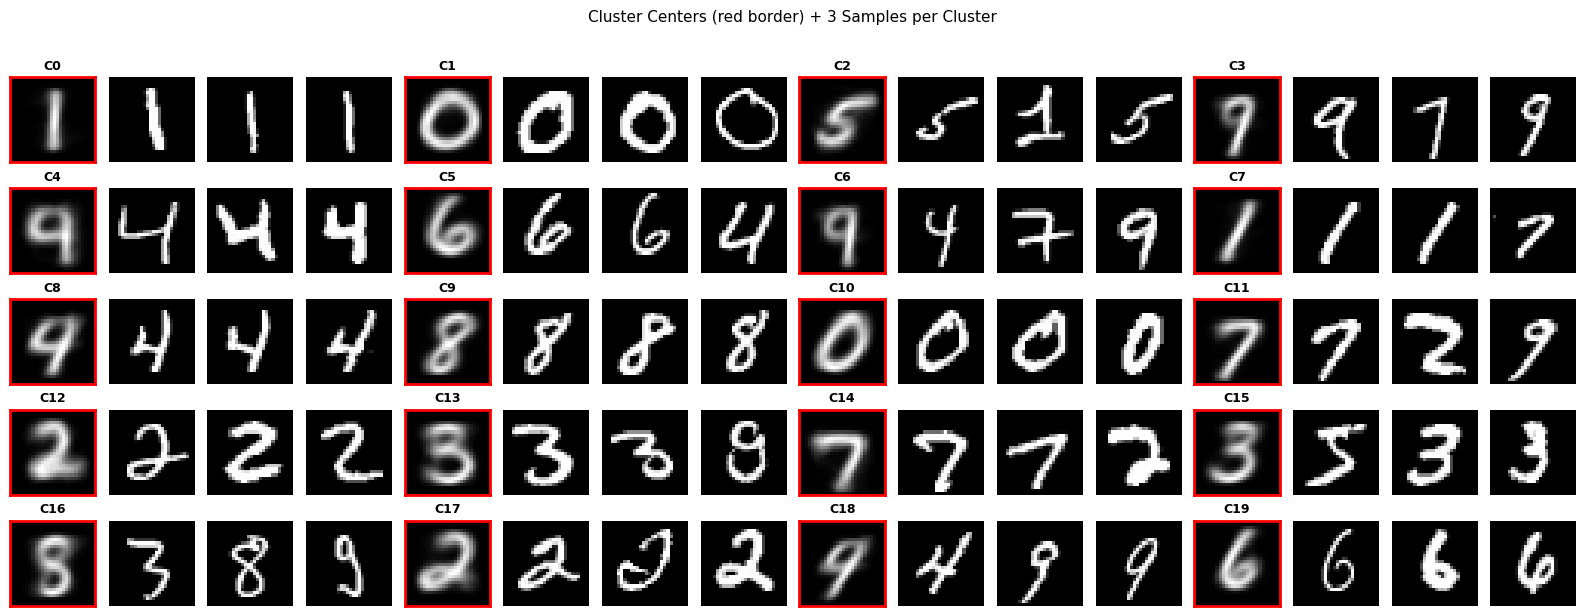

In [120]:
# Visualize each cluster: show center + 3 sample images
# This helps us manually identify what digit each cluster represents
centers_20 = centers_20.reshape(20, 28, 28)

fig, axes = plt.subplots(5, 16, figsize=(16, 6))

for cluster_id in range(20):
    # Find indices of samples in this cluster
    sample_indices = np.where(cluster_labels_20 == cluster_id)[0]
    row = cluster_id // 4
    col_start = (cluster_id % 4) * 4
    
    # First image: cluster center (with red border)
    ax = axes[row, col_start]
    ax.imshow(centers_20[cluster_id], cmap='gray')
    ax.set_title(f"C{cluster_id}", fontsize=9, fontweight='bold')
    for spine in ax.spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(2)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Next 3 images: sample digits from this cluster
    for j in range(3):
        ax = axes[row, col_start + j + 1]
        if j < len(sample_indices):
            ax.imshow(X_digits[sample_indices[j]].reshape(28, 28), cmap='gray')
        ax.axis('off')

plt.suptitle("Cluster Centers (red border) + 3 Samples per Cluster", fontsize=11, y=1.02)
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()


We have the clusters but the cluster labels do not match with the images. Relable the clusters below. Try to do the best accurate labeling, but note that some clusters still contain a mix of digits.

In [121]:
# Assign digit labels (0-9) to each cluster based on visual inspection
### BEGIN SOLUTION
cluster_labels_20_manual = [1, 0, 5, 9,
                            4, 6, 9, 1, 
                            4, 8, 0, 7,
                            2, 3, 7, 3,
                            8, 2, 9, 6]
### END SOLUTION

print("\nCluster labels:", cluster_labels_20_manual)


Cluster labels: [1, 0, 5, 9, 4, 6, 9, 1, 4, 8, 0, 7, 2, 3, 7, 3, 8, 2, 9, 6]


In [122]:
# Propagate labels: assign each sample the digit label of its cluster
# cluster_labels_20[i] gives cluster ID (0-19) for sample i
# cluster_labels_20_manual[c] gives the digit (0-9) we assigned to cluster c
y_pred_20 = np.array([cluster_labels_20_manual[c] for c in cluster_labels_20])

accuracy_20 = accuracy_score(y_digits, y_pred_20)
print(f"Accuracy with K=20: {accuracy_20:.1%}")
print(f"Accuracy with K=10: {accuracy_k10:.1%}")
print(f"\nImprovement: {(accuracy_20 - accuracy_k10)*100:.1f} percentage points")

Accuracy with K=20: 71.0%
Accuracy with K=10: 56.0%

Improvement: 15.0 percentage points


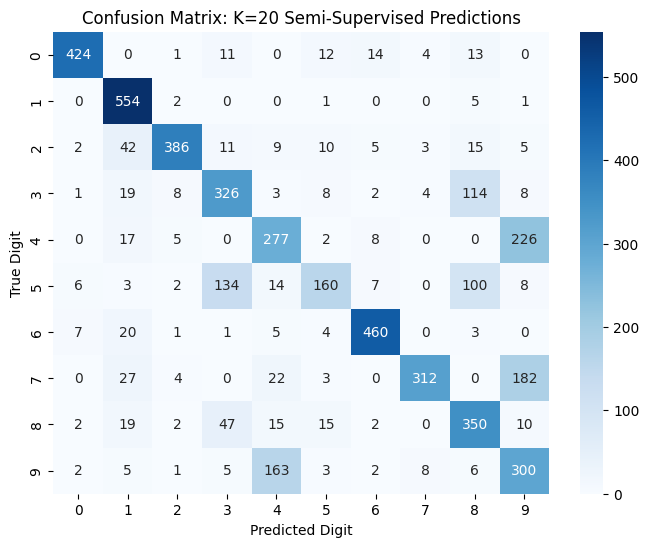

We labeled only 20 cluster centers to classify 5000 samples!


In [ ]:
# Confusion matrix for K=20 predictions
cm_20 = confusion_matrix(y_digits, y_pred_20)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_20, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Digit')
plt.ylabel('True Digit')
plt.title('Confusion Matrix: K=20 Semi-Supervised Predictions')
plt.show()


### Questions: 
- Why did the semi-supervised approach with K=20 work better than clustering with K=10?
- How many labels did you provide in this case? How does this compare with the number of labels needed for supervised learning? What is the impact on accuracy?

**Answer:** 
* With K=10, each cluster had to represent exactly one digit, but handwritten digits have many variations (slant, thickness, style). So different variations of different digits may be clustered together. With K=20, each digit can be represented by multiple clusters (roughly 2 per digit), allowing different writing styles of the same digit to form separate clusters. This reduces mixing of different digits within clusters, although does not fully solve it. 

* We provided only 20 labels, compared with 5,000 labels. But we paid a price in accuracy, since for knn the accuracy is 90+%. This shows the potential but we didn't have the best implementation here.

---
## Part 3: Image Compression

k-Means can compress images by reducing the number of colors. Instead of storing RGB values (24 bits per pixel), we store:
- A **palette** of K colors (the cluster centers)
- An **index** for each pixel (which palette color to use)

With K=32 colors, each pixel needs only 5 bits instead of 24 — nearly 5x compression!

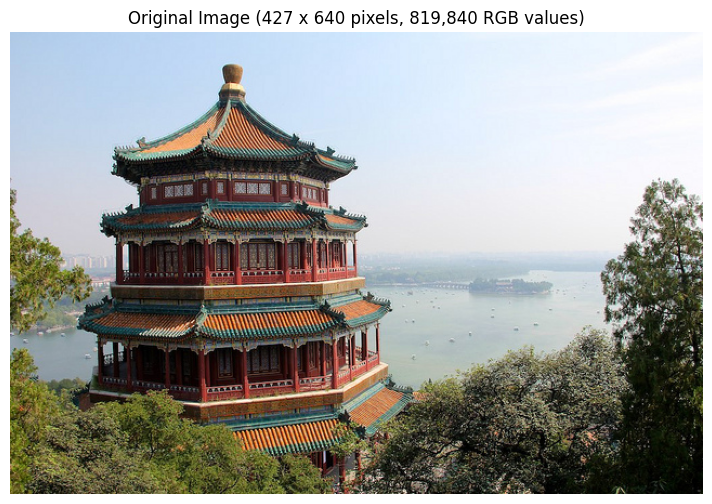

In [124]:
# Load a sample image from sklearn
from sklearn.datasets import load_sample_image

# img has shape (H, W, 3) where 3 = RGB channels
img = load_sample_image("china.jpg")

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.title(f"Original Image ({img.shape[0]} x {img.shape[1]} pixels, {img.shape[0]*img.shape[1]*3:,} RGB values)")
plt.axis('off')
plt.show()

In [129]:
def compress_image(img, n_colors):
    """
    Compress an image by reducing its color palette using k-Means.
    
    Parameters:
        img: (H, W, 3) array - the input image
        n_colors: number of colors in the compressed image
    
    Returns:
        indices: (H, W) array - index of palette color for each pixel
        palette: (n_colors, 3) array - the color palette
    """
    # TODO: Implement image compression using k-Means
    
    ### BEGIN SOLUTION
    h, w, d = img.shape
    pixels = img.reshape((h * w, d))
    
    kmeans = KMeans(n_clusters=n_colors, random_state=42, n_init=10)
    kmeans.fit(pixels)
    palette = kmeans.cluster_centers_
    
    indices = kmeans.labels_.reshape((h, w))
    ### END SOLUTION

    palette = palette.astype(np.uint8) # this ensures the palette is in the correct format
    
    return indices, palette

In [130]:
# Compress the image to 32 colors
n_colors = 32
indices, palette = compress_image(img, n_colors)

# indices: (H, W) array where each value is 0 to n_colors-1
# palette: (n_colors, 3) array of RGB colors
print(f"Original: {img.shape[0]} x {img.shape[1]} x 3 RGB values")
print(f"Compressed: {indices.shape[0]} x {indices.shape[1]} indices + palette of {n_colors} colors")

Original: 427 x 640 x 3 RGB values
Compressed: 427 x 640 indices + palette of 32 colors


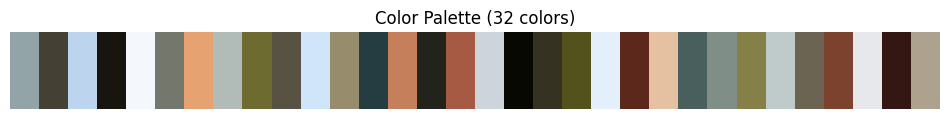

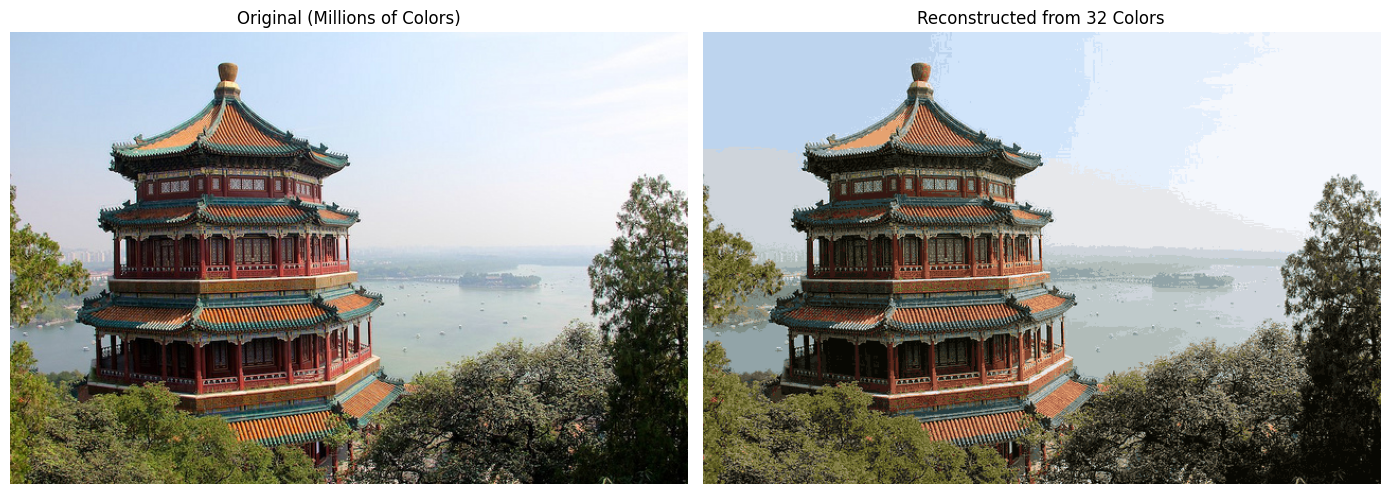

In [131]:
# Display the color palette (the K cluster centers)
plt.figure(figsize=(12, 1))
plt.imshow([palette], aspect='auto')
plt.title(f"Color Palette ({n_colors} colors)")
plt.axis('off')
plt.show()

# Compare original and reconstructed image
# To reconstruct: look up each pixel's color from the palette using its index
# palette[indices] uses numpy indexing: for each index in indices, get that row from palette
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(img)
axes[0].set_title("Original (Millions of Colors)")
axes[0].axis('off')

axes[1].imshow(palette[indices])
axes[1].set_title(f"Reconstructed from {n_colors} Colors")
axes[1].axis('off')

plt.tight_layout()
plt.show()